# Theory Analysis at given quantile across latitudes
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [1]:
import copy
import sys
import os

import warnings


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx, get_temp_adiabat
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [3]:
dir_out = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/hottest_lat_lon'
exp_id = ['pre_industrial', 'co2_2x']
n_exp = len(exp_id)
exp_names = []
for i in range(n_exp):
    if exp_id[i] == 'pre_industrial':
        exp_names.append('e.e20.E1850TEST.f09_g17.daily_output')
    else:
        exp_names.append(f'e.e20.E1850TEST.f09_g17.{exp_id[i]}_daily_output')
# exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_2x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']

# if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
#     raise ValueError('Quantiles change between datasets')
#
# if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
#     raise ValueError('Latitudes change between datasets')
#
# if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
#     raise ValueError('Surface change between datasets')
lat_min = -90
lat_max = 90
ds = []
quant = []     # record which quantile averaged above
for i in tqdm(range(n_exp)):
    ds_use = xr.open_dataset(os.path.join(dir_out, f'{exp_id[i]}/output.nd2'))
    quant.append(int(ds_use.quant))
    ds.append(ds_use.isel(quant=0, drop=True).sel(lat=slice(lat_min, lat_max)).load())
    # Find all latitudes with at least one longitude of given surface
    # ds[i]['is_surf'] = (ds[i].landmask.sum(dim='lon')!=0) * (ds[i].surface=='land') + (
    #         np.invert(ds[i].landmask).sum(dim='lon')!=0) * (ds[i].surface=='ocean')
    # ds[i] = ds[i].where(ds[i].is_surf)      # set values to nan where there is none of that surface at given latitude
ds_av = xr.open_dataset(os.path.join(dir_out, f'{exp_id[0]}/av/output.nd2')).isel(quant=0, drop=True).sel(lat=slice(lat_min, lat_max))[['Z3', 'T']].load()
ds_av = area_weighting(ds_av).mean(dim=['lat', 'lon'])          # take global av

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# Get pressure info
ind_surf = 0
ind_ft = 1
pressure_surf = float(ds[0].lev[ind_surf]) * 100
pressure_ft = float(ds[0].lev[ind_ft]) * 100

In [19]:
# Compute approx CAPE
if 'rh' not in ds:
    warnings.warn('RH not in ds, so calculating from sphum')
    ds['rh'] = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
n_lon = ds[0].lon.size
n_lat = ds[0].lat.size
cape_approx = np.zeros((n_exp, n_lat, n_lon))
for i in range(n_exp):
    for j in range(n_lat):
        cape_approx[i, j] = get_cape_approx(ds[i].T.isel(lev=ind_surf, lat=j).to_numpy(), ds[i].rh.isel(lat=j).to_numpy(),
                                            pressure_surf, pressure_ft, ds[i].T.isel(lev=ind_ft, lat=j).to_numpy(),
                                            ds[i].mse_lapse.isel(lat=j).to_numpy())[0]
    ds[i]['cape_approx'] = ds[i].mse_lapse*0 + cape_approx[i]      # use mse_lapse as a base and add to it, as have same dimensions
# Get dataset which is difference between datasets - need to drop boolean variables to do the subtraction
var_bool = ['use_in_calc', 'landmask', 'gw']
ds_diff = ds[1].drop_vars(var_bool) - ds[0].drop_vars(var_bool)       # drop b

## Geopotential Height - Temperature Relation
### Lapse Rate
#### Zhang 2023
In the Zhang 2023 formulation, the factor $\zeta = \frac{z_{500} - z_s}{T_{500}}$ is assumed constant on all days, and thus takes its value in the global average, $\overline{\beta}$.

The lapse rate is related to $\zeta$ through $\Gamma = \frac{T_s-T_{500}}{z_{500}-z_s} = \frac{T_s/T_{500}-1}{\zeta}$

The key point is that $\zeta$ and not the lapse rate itself is constant across all days.

#### My theory
In my theory, the lapse rate is given by:

$$
\frac{1}{\Gamma} = \frac{2R^{\dagger}}{g\ln\left(\frac{T_s}{T_{FT}}\right)} \approx \frac{2R^{\dagger}}{g}\left(\frac{T_{FT}}{T_s-T_{FT}} + \frac{1}{2}\right)
$$
where we have introduced for convenience a modified gas constant $R^{\dagger} \equiv R\ln \left(\frac{p_s}{p_{FT}}\right)/2$, and the approximation arises from re-writing the denominator in the form $\ln(1+y)$, with $y = \frac{T_s-T_{FT}}{T_{FT}}$.

Both estimates seem pretty similar.

In [20]:
def get_lapse_theory(temp_surf, temp_ft, p_surf=pressure_surf, p_ft=pressure_ft, taylor=True):
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return g / 2 / R_mod / (temp_ft/(temp_surf - temp_ft) + 0.5)
    else:
        return g * np.log(temp_surf/temp_ft) / 2 / R_mod

def get_lapse_rate_zhang(temp_surf, temp_ft):
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    return (temp_surf/temp_ft - 1) / zeta_factor

def get_lapse_rate(temp_surf, temp_ft, z_surf, z_ft):
    return (temp_surf - temp_ft) / (z_ft - z_surf)

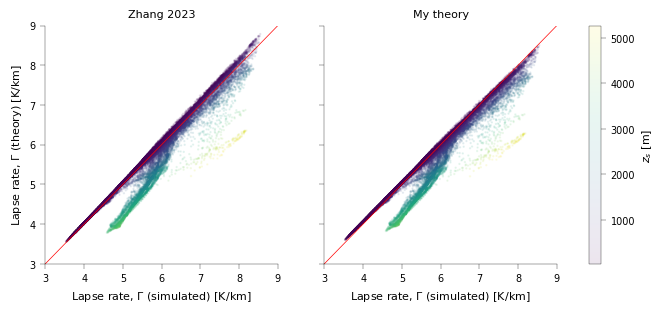

In [21]:
i = 0
show_scatter = True
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
im = ax[0].scatter(get_lapse_rate(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), ds[i].Z3.isel(lev=0), ds[i].Z3.isel(lev=1))*1000,
                   get_lapse_rate_zhang(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1))*1000,
                   alpha=0.1, c=ds[0].Z3.isel(lev=0), cmap='viridis', s=0.5)
im = ax[1].scatter(get_lapse_rate(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), ds[i].Z3.isel(lev=0), ds[i].Z3.isel(lev=1))*1000,
                   get_lapse_theory(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), taylor=False)*1000,
                   alpha=0.1, c=ds[0].Z3.isel(lev=0), cmap='viridis', s=0.5)
plt.colorbar(im, ax=ax, label='$z_{s}$ [m]')
ax_lim = [3, 9]
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('Lapse rate, $\Gamma$ (simulated) [K/km]')
ax[1].set_xlabel('Lapse rate, $\Gamma$ (simulated) [K/km]')
ax[0].set_ylabel('Lapse rate, $\Gamma$ (theory) [K/km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

### Height
Given the lapse rate, it is a simple conversion to get an estimate of the geopotential height relative to the surface, $z_{FT}-z_s$. Again, it seems that both theories do equally as well, maybe the Zhang 2023 theory is slightly better.

In [22]:
def get_z_theory(temp_surf, temp_ft, p_surf=pressure_surf, p_ft=pressure_ft, taylor=True):
    # Returns z_ft - z_s
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return R_mod/g * (temp_surf + temp_ft)
    else:
        return (temp_surf - temp_ft) * 2 * R_mod / g / np.log(temp_surf / temp_ft)

def get_z_theory_zhang(temp_ft):
    # Returns z_ft - z_s theory
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    return zeta_factor * temp_ft

In [23]:
z_diff = {'simulated': [(ds[i].Z3.isel(lev=1)-ds[i].Z3.isel(lev=0)) for i in range(n_exp)],
          'zhang': [get_z_theory_zhang(ds[i].T.isel(lev=1)) for i in range(n_exp)],
          'theory': [get_z_theory(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1)) for i in range(n_exp)]}

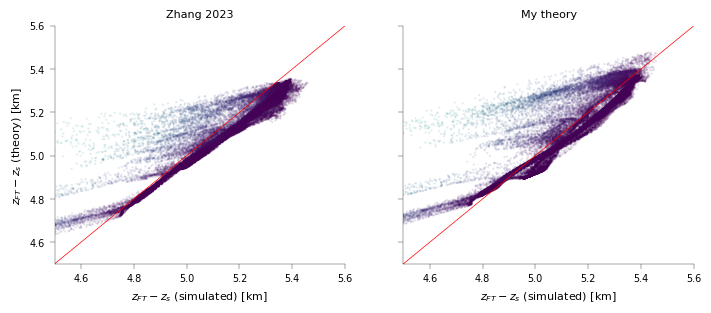

In [24]:
i=0
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].scatter(z_diff['simulated'][i]/1000, z_diff['zhang'][i]/1000,
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax[1].scatter(z_diff['simulated'][i]/1000, z_diff['theory'][i]/1000,
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax_lim = [4.5, 5.6]
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('$z_{FT}-z_s$ (simulated) [km]')
ax[1].set_xlabel('$z_{FT}-z_s$ (simulated) [km]')
ax[0].set_ylabel('$z_{FT}-z_s$ (theory) [km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

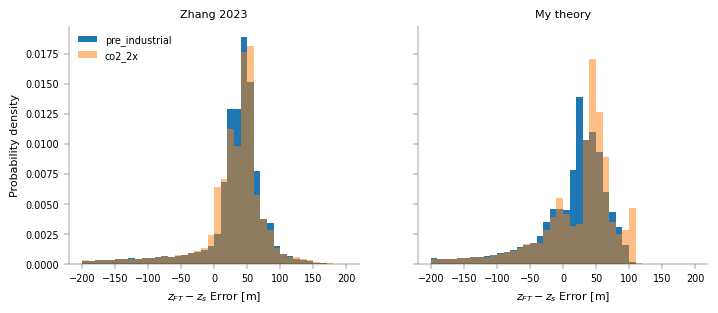

In [25]:
hist_bins = np.linspace(-200, 200, 41)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
for i in range(n_exp):
    ax[0].hist((z_diff['simulated'][i]-z_diff['zhang'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1, label=exp_id[i])
    ax[1].hist((z_diff['simulated'][i]-z_diff['theory'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1)
ax[0].set_xlabel('$z_{FT}-z_s$ Error [m]')
ax[1].set_xlabel('$z_{FT}-z_s$ Error [m]')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
ax[0].legend()
plt.show()

### Height Change
The height change with warming also looks slightly better for the Zhang theory, but there is not much in it.

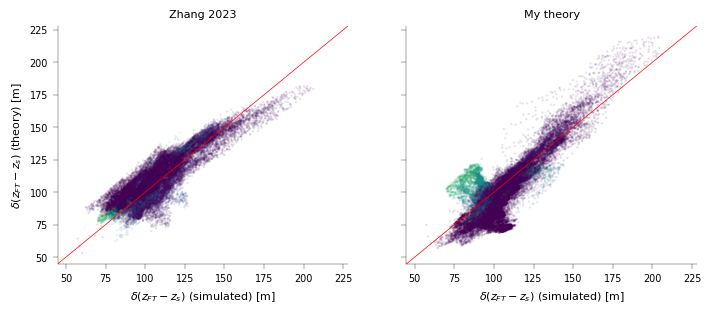

In [26]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].scatter(np.diff(z_diff['simulated'], axis=0).squeeze(), np.diff(z_diff['zhang'], axis=0).squeeze(),
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax[1].scatter(np.diff(z_diff['simulated'], axis=0).squeeze(), np.diff(z_diff['theory'], axis=0).squeeze(),
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax_lim = [150, 450]
ax_lim = ax[0].get_ylim()
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('$\delta (z_{FT}-z_s)$ (simulated) [m]')
ax[1].set_xlabel('$\delta (z_{FT}-z_s)$ (simulated) [m]')
ax[0].set_ylabel('$\delta (z_{FT}-z_s)$ (theory) [m]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

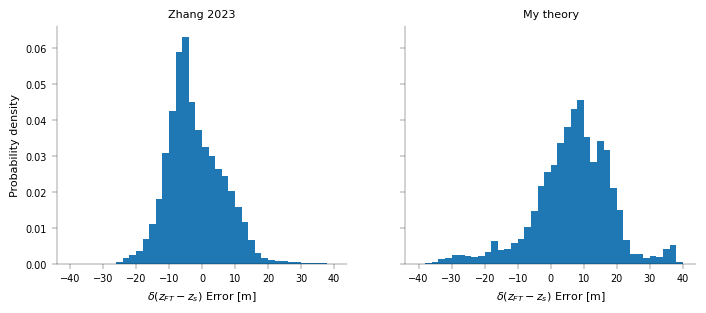

In [27]:
hist_bins = np.linspace(-40, 40, 41)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].hist((np.diff(z_diff['simulated'], axis=0).squeeze()-
            np.diff(z_diff['zhang'], axis=0).squeeze()).flatten(), bins=hist_bins, density=True)
ax[1].hist((np.diff(z_diff['simulated'], axis=0).squeeze()-
            np.diff(z_diff['theory'], axis=0).squeeze()).flatten(), bins=hist_bins, density=True)
# ax[1].hist((z_diff['simulated'][i]-z_diff['theory'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1)
ax[0].set_xlabel('$\delta (z_{FT}-z_s)$ Error [m]')
ax[1].set_xlabel('$\delta (z_{FT}-z_s)$ Error [m]')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
plt.show()

## Assessing Theories
The Zhang 2023 theory assumes no change in specific humidity with warming, and also CQE - that CAPE quantified through $\epsilon=h_s-h_{FT}^*$ remains constant with warming.

This theory does not match the simulated changes well, because over land, specific humidity increases. This is why the theory basically systematically over-estimates the simulated change everywhere.

The regions where the theory under-estimates the simulated change is because there is a large increase in $\epsilon=h_s-h_{FT}^*$, which counteracts the specific humidity effect.


In [28]:
def get_temp_change_zhang_theory(temp_ft, sphum=None, p_ft=pressure_ft):
    temp_ft_change = temp_ft[1] - temp_ft[0]
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    q_sat_change = sphum_sat(temp_ft[1], p_ft) - sphum_sat(temp_ft[0], p_ft)
    temp_change =  (1 + g*zeta_factor/c_p) * temp_ft_change + L_v/c_p * q_sat_change
    if sphum is None:
        return temp_change
    else:
        return temp_change - L_v/c_p * (sphum[1]-sphum[0])
temp_surf_change_zhang = get_temp_change_zhang_theory([ds[0].T.isel(lev=ind_ft), ds[1].T.isel(lev=ind_ft)])
# temp_surf_change_zhang = get_temp_change_zhang_theory([ds[0].T.isel(lev=ind_ft), ds[1].T.isel(lev=ind_ft)],
#                                                        [ds[0].Q.isel(lev=ind_surf), ds[1].Q.isel(lev=ind_surf)])

In [29]:
def add_gridlines(ax, left_labels=True, bottom_labels=True, fontsize=8, color='k', alpha=0.1, lon=None, lat=None):
    if lon is None:
        lon = [-120, -60, 0, 60, 120]
    if lat is None:
        lat = [-60, -30, 0, 30, 60]
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color=color, alpha=alpha)
    gl.xlocator = plt.FixedLocator(lon)
    gl.ylocator = plt.FixedLocator(lat)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left_labels
    gl.bottom_labels = bottom_labels
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    return gl

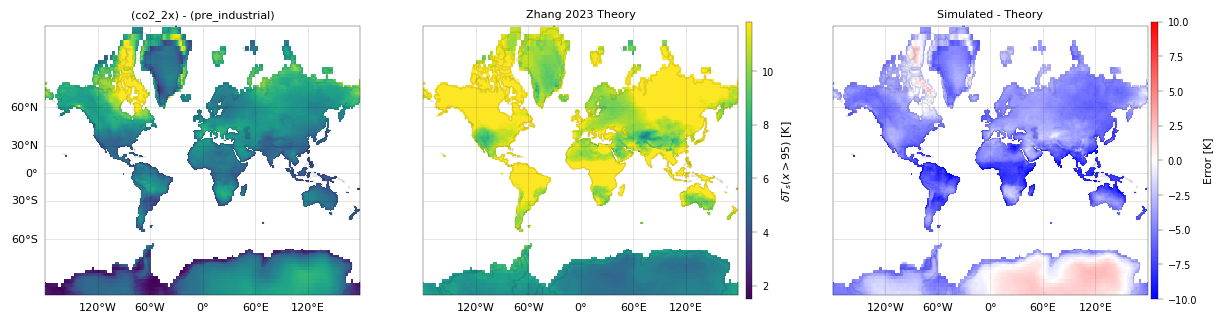

In [30]:
show_ocean = False
mask_plot = ds[0].landmask>=0 if show_ocean else ds[0].landmask
ax_lims_temp_change = [ds_diff.T.isel(lev=ind_surf).min(), 0.8*ds_diff.T.isel(lev=ind_surf).max()]
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.T.isel(lev=ind_surf).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, temp_surf_change_zhang.where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax[:2], label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (ds_diff.T.isel(lev=ind_surf) - temp_surf_change_zhang).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='bwr')
plt.colorbar(im, ax=ax[2:], label=f'Error [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
ax[1].set_title('Zhang 2023 Theory')
ax[2].set_title('Simulated - Theory')
plt.show()

### CQE Assumption
The CQE assumption is not great in ocean regions, where there seems to be an increase in CAPE with warming. Land regions at low latitudes show fairly small changes with warming.

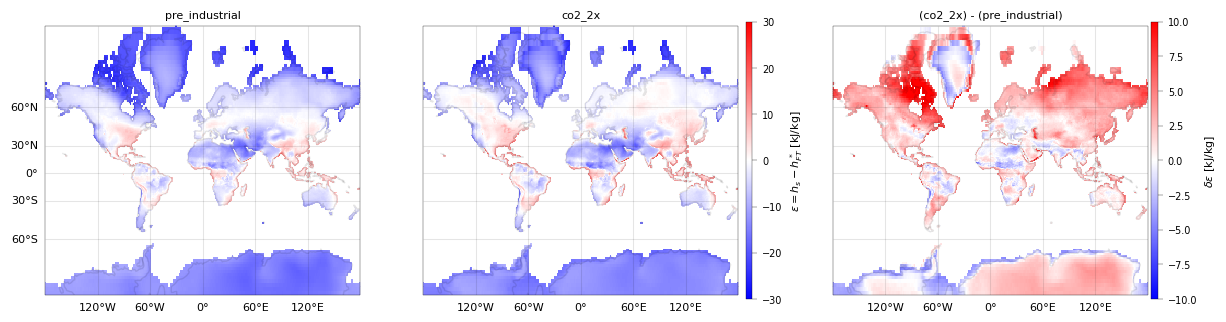

In [31]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, ds[i].mse_lapse_p_approx.where(mask_plot),
                     transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='bwr')
    ax[i].set_title(f'{exp_id[i]}')
plt.colorbar(im, ax=ax[:2], label='$\epsilon = h_s - h_{FT}^*$ [kJ/kg]', aspect=40, pad=0.01, fraction=0.03)

im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.mse_lapse_p_approx.where(mask_plot),
                      transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='bwr')
ax[2].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
plt.colorbar(im, ax=ax[2:], label=f'$\delta \epsilon$ [kJ/kg]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
plt.show()

### Specific Humidity
Below, we see that specific humidity is clearly not constant over tropical ocean, but seems to be a reasonable approximation over much of tropical and mid-latitude land.

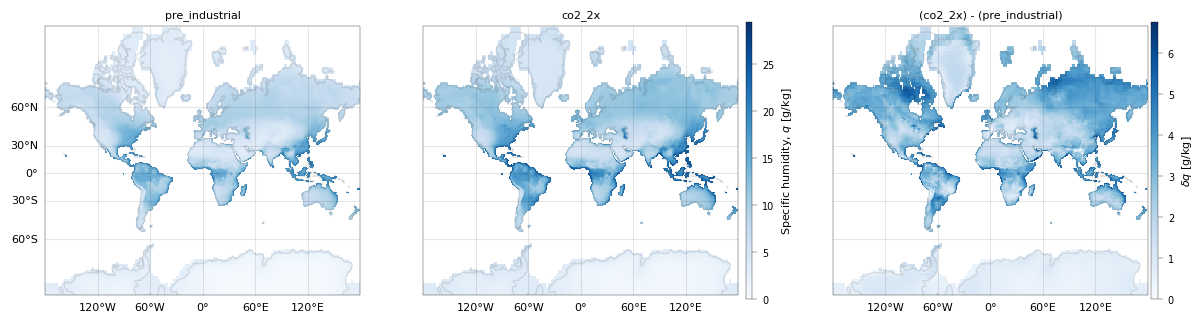

In [32]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, ds[i].Q.isel(lev=ind_surf).where(mask_plot)*1000,
                     transform=ccrs.PlateCarree(), vmin=0, vmax=ds[1].Q.isel(lev=ind_surf).max()*1000, cmap='Blues')
    ax[i].set_title(f'{exp_id[i]}')
plt.colorbar(im, ax=ax[:2], label='Specific humidity, $q$ [g/kg]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.Q.isel(lev=ind_surf).where(mask_plot)*1000,
                      transform=ccrs.PlateCarree(), vmin=0, vmax=0.9*ds_diff.Q.isel(lev=ind_surf).max()*1000, cmap='Blues')
ax[2].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
plt.colorbar(im, ax=ax[2:], label=f'$\delta q$ [g/kg]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
plt.show()

## My Theory
Below, we see that my theory does significantly better at capturing the trend with warming.

In [33]:
def get_exp_quant_array(ds_list, var, lat_ind, lev_ind=None):
    # Returns an n_exp x n_lon array of given variable where ds_list contains n_exp datasets
    var_ind = {'lat': lat_ind, 'lev': lev_ind}
    dims = ds_list[0][var].dims & var_ind.keys()        # only consider dimensions in both variable and var_ind
    return np.asarray([ds_list[i][var].isel({key: var_ind[key] for key in dims}).to_numpy() for i in range(len(ds_list))])

In [34]:
# Set reference dataset to be average over all regions
ds_ref = [area_weighting(ds[i][['T', 'rh']]).mean(dim=['lat', 'lon']) for i in range(n_exp)]
ds_ref[1]['rh'] = ds_ref[0]['rh']    # set ref RH to be the same in all cases
temp_surf_ref_change = float(ds_ref[1].T.isel(lev=ind_surf) - ds_ref[0].T.isel(lev=ind_surf))
# Compute FT temperature of reference day if following exact adiabat
j=0
temp_ft_ref_adiabat = get_temp_adiabat(get_exp_quant_array(ds_ref, 'T', j, ind_surf), get_exp_quant_array(ds_ref, 'rh', j) *
             sphum_sat(get_exp_quant_array(ds_ref, 'T', j, ind_surf), pressure_surf), pressure_surf, pressure_ft)

In [36]:
sf_theory = np.zeros((n_lat, n_lon))
sf_theory_breakdown = {key: np.zeros((n_lat, n_lon)) for key in
                       ['temp_ft_change', 'r_change', 'temp_anom', 'r_anom', 'cape_change']}
for j in tqdm(range(n_lat)):
    sf_theory[j], info_coef, _, info_cont = \
        get_scale_factor_theory(get_exp_quant_array(ds_ref, 'T', j, ind_surf), get_exp_quant_array(ds, 'T', j, ind_surf),
                                get_exp_quant_array(ds_ref, 'rh', j), get_exp_quant_array(ds, 'rh', j),
                                get_exp_quant_array(ds, 'T', j, ind_ft), get_exp_quant_array(ds, 'mse_lapse', j),
                                pressure_surf, pressure_ft, cape_form=True)
    for key2 in sf_theory_breakdown:
        sf_theory_breakdown[key2][j] = info_cont[key2]

# Compute theoretical estimate of the ref temp change, as is not exactly equal to actual value
j = 0
# Compute scaling factor of the ref temp change, assuming exact adiabat. Should be 1, but is not due to approximations
sf_theory_ref, _, _, info_cont = get_scale_factor_theory(get_exp_quant_array(ds_ref, 'T', j, ind_surf),
                                                         get_exp_quant_array(ds_ref, 'T', j, ind_surf)[:, np.newaxis],
                                                         get_exp_quant_array(ds_ref, 'rh', j), get_exp_quant_array(ds_ref, 'rh', j)[:, np.newaxis],
                                                         temp_ft_ref_adiabat[:, np.newaxis], np.zeros((2, 1)), pressure_surf, pressure_ft, cape_form=True)
temp_surf_ref_change_theory = float(temp_surf_ref_change * sf_theory_ref)
sf_theory = sf_theory - sf_theory_ref + 1       # modify sf_theory to account for theory estimated ref change wrong
sf_theory = ds[0].landmask*0 + sf_theory   # convert to xarray
temp_surf_change_theory = sf_theory * temp_surf_ref_change
sf_theory_breakdown['temp_ft_change'] -= info_cont['temp_ft_change']    # normalise relative to reference value - only ft_change term in ref theoretical sf
print(np.abs(sf_theory-1 - sum([sf_theory_breakdown[key] for key in sf_theory_breakdown])).max())   # sanity check that sum of terms equals scaling factor

# convert breakdown into xarray
for key in sf_theory_breakdown:
    sf_theory_breakdown[key] = ds[0].landmask*0 + sf_theory_breakdown[key]

  0%|          | 0/192 [00:00<?, ?it/s]

<xarray.DataArray 'landmask' ()> Size: 8B
array(8.21565038e-15)


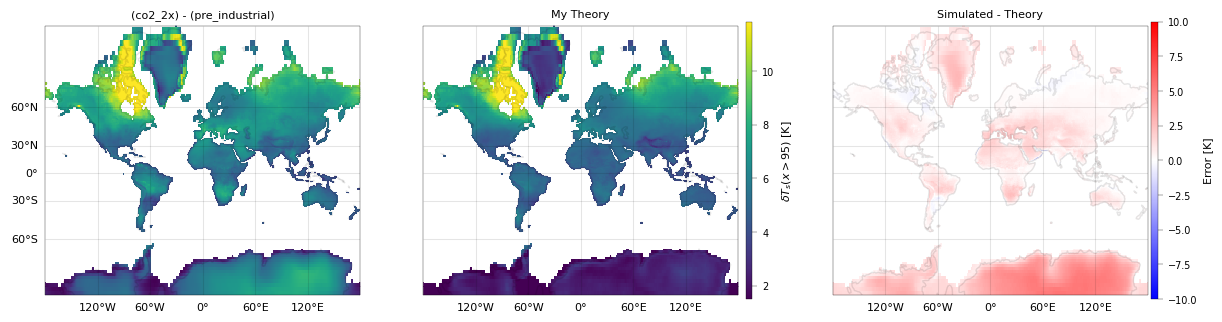

In [37]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.T.isel(lev=ind_surf).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, temp_surf_change_theory.where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax[:2], label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (ds_diff.T.isel(lev=ind_surf) - temp_surf_change_theory).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='bwr')
plt.colorbar(im, ax=ax[2:], label=f'Error [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
ax[1].set_title('My Theory')
ax[2].set_title('Simulated - Theory')
plt.show()

### Climatological mechanisms
The climatological mechanisms indicate amplified warming in regions that are dry and hot in the current climate. From these mechanisms alone, we see that we would expect the tropics to warm the most.

We see that the magnitude in the tropics is approximately captured by these mechanisms alone, and it also explains some of the details. E.g. South Africa warms more than equatorial Africa because it is drier in the current climate. Also, that land warms more than ocean.

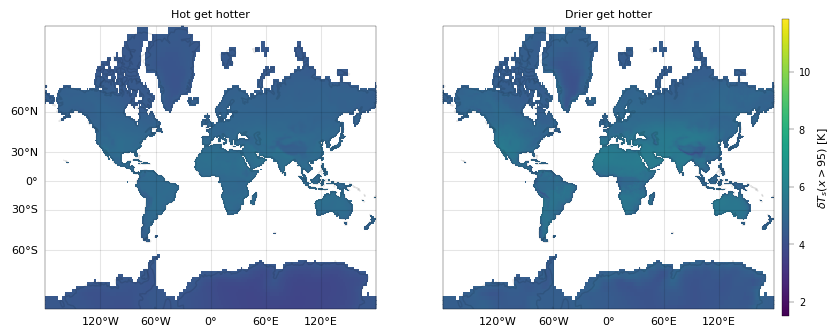

In [38]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['temp_anom'].where(mask_plot)+1)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['r_anom'].where(mask_plot)+1)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax, label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.01)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title('Hot get hotter')
ax[1].set_title('Drier get hotter')
plt.show()

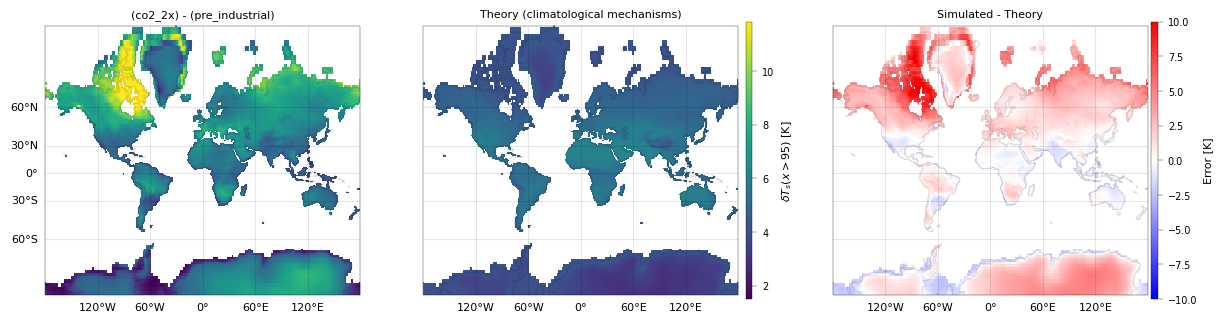

In [39]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.T.isel(lev=ind_surf).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['temp_anom']+sf_theory_breakdown['r_anom']+1).where(mask_plot)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax[:2], label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (ds_diff.T.isel(lev=ind_surf) -
                                             (sf_theory_breakdown['temp_anom']+sf_theory_breakdown['r_anom']+1)*temp_surf_ref_change).where(mask_plot),
                      transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='bwr')
plt.colorbar(im, ax=ax[2:], label=f'Error [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
ax[1].set_title('Theory (climatological mechanisms)')
ax[2].set_title('Simulated - Theory')
plt.show()

### Change Mechanisms
Below, we see that, maybe surprisingly, the FT change mechanism is not particularly important for explaining spatial differences. Both the relative humidity change and simple CAPE change mechanisms are very significant though.

At high latitudes, sCAPE is negative, so the increase jsut reflects a move towards a convective regime, and the theory is maybe not appropriate here. In the tropics over ocean, sCAPE becomes more positive though, indicating a potential role for entrainment.

The relative humidity mainly decreases over NH land, but not it doesn't appear that this occurs to the extent that specific humidity remains constant.

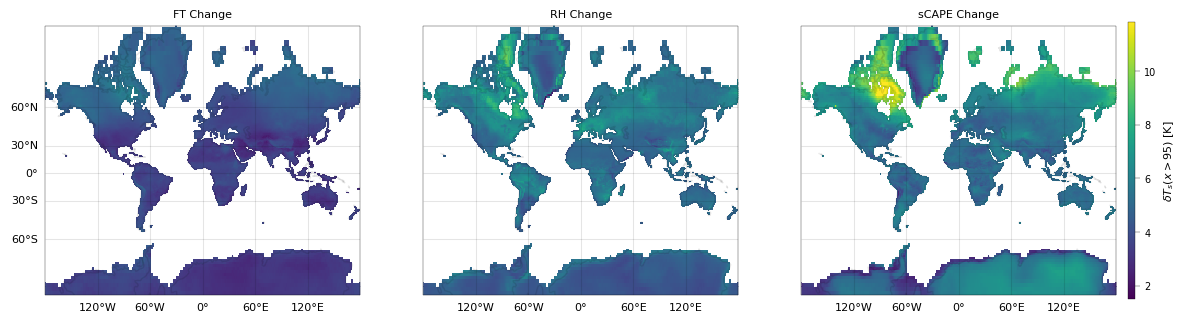

In [40]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['temp_ft_change']+1).where(mask_plot)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
ax[1].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['r_change']+1).where(mask_plot)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['cape_change']+1).where(mask_plot)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax, label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title('FT Change')
ax[1].set_title('RH Change')
ax[2].set_title('sCAPE Change')
plt.show()

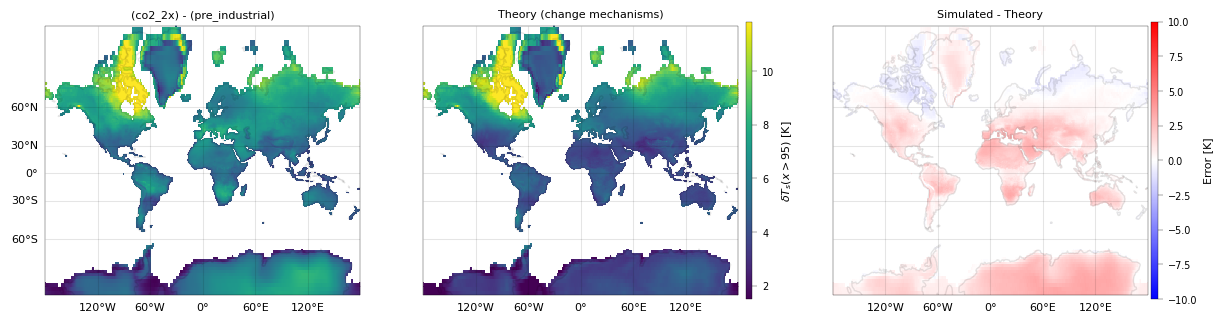

In [41]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.T.isel(lev=ind_surf).where(mask_plot),
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, (sf_theory_breakdown['temp_ft_change']+sf_theory_breakdown['r_change']+
                                             sf_theory_breakdown['cape_change']+1).where(mask_plot)*temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=ax_lims_temp_change[0], vmax=ax_lims_temp_change[1], cmap='viridis')
plt.colorbar(im, ax=ax[:2], label=f'$\delta T_s(x>{quant[0]})$ [K]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (ds_diff.T.isel(lev=ind_surf) -
                                             (sf_theory_breakdown['temp_ft_change']+sf_theory_breakdown['r_change']+
                                             sf_theory_breakdown['cape_change']+1)*temp_surf_ref_change).where(mask_plot),
                      transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='bwr')
plt.colorbar(im, ax=ax[2:], label=f'Error [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[0].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
ax[1].set_title('Theory (change mechanisms)')
ax[2].set_title('Simulated - Theory')
plt.show()

### Variables
Below, I look at each of the variables that change in turn.

The simple CAPE distribution is quite striking, in that it is near-zero over NH land, but positive over ocean in the tropics, while land in the tropics seems to show negative values - maybe because these regions are too dry to trigger convection.
There also seems to be a patch of negative sCAPE to the west of tropical land in the southern hemisphere.

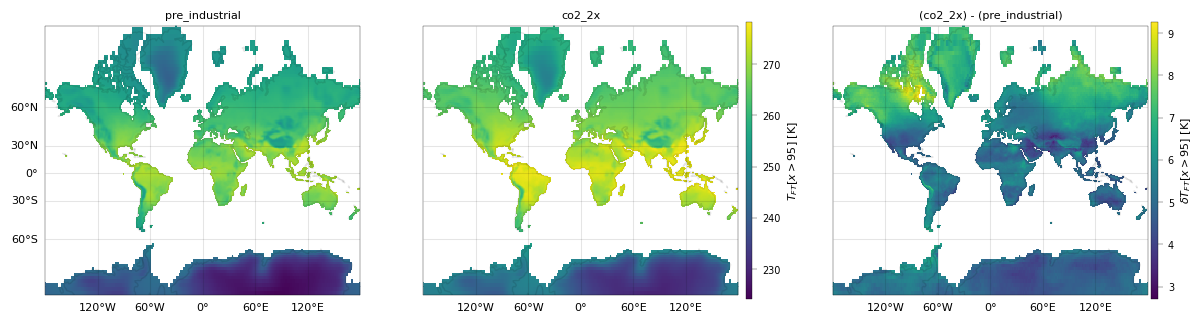

In [42]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, ds[i].T.isel(lev=ind_ft).where(mask_plot),
                     transform=ccrs.PlateCarree(), vmin=ds[0].T.isel(lev=ind_ft).where(mask_plot).min(),
                     vmax=ds[1].T.isel(lev=ind_ft).where(mask_plot).max(), cmap='viridis')
    ax[i].set_title(f'{exp_id[i]}')
plt.colorbar(im, ax=ax[:2], label=f'$T_{"{FT}"}[x>{quant[0]}]$ [K]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.T.isel(lev=ind_ft).where(mask_plot),
                      transform=ccrs.PlateCarree(), vmin=ds_diff.T.isel(lev=ind_ft).where(mask_plot).min(),
                      vmax=ds_diff.T.isel(lev=ind_ft).where(mask_plot).max())
plt.colorbar(im, ax=ax[2:], label=f'$\delta T_{"{FT}"}[x>{quant[0]}]$ [K]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
ax[2].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
plt.show()

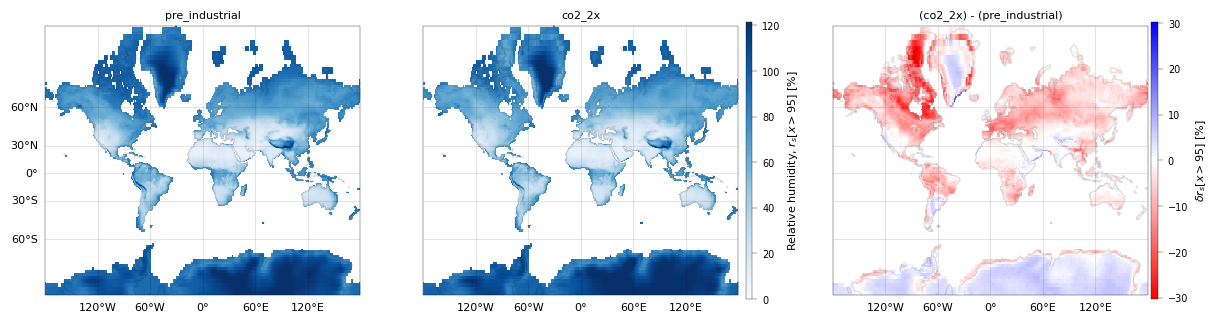

In [43]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, ds[i].rh.where(mask_plot)*100,
                     transform=ccrs.PlateCarree(), vmin=0, vmax=0.9*ds[1].rh.max()*100, cmap='Blues')
    ax[i].set_title(f'{exp_id[i]}')
plt.colorbar(im, ax=ax[:2], label=f'Relative humidity, $r_s[x>{quant[0]}]$ [%]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.rh.where(mask_plot)*100,
                      transform=ccrs.PlateCarree(), vmin=-0.9*np.abs(ds_diff.rh).max()*100, vmax=0.9*np.abs(ds_diff.rh).max()*100, cmap='bwr_r')
ax[2].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
plt.colorbar(im, ax=ax[2:], label=f'$\delta r_s[x>{quant[0]}]$ [%]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
plt.show()

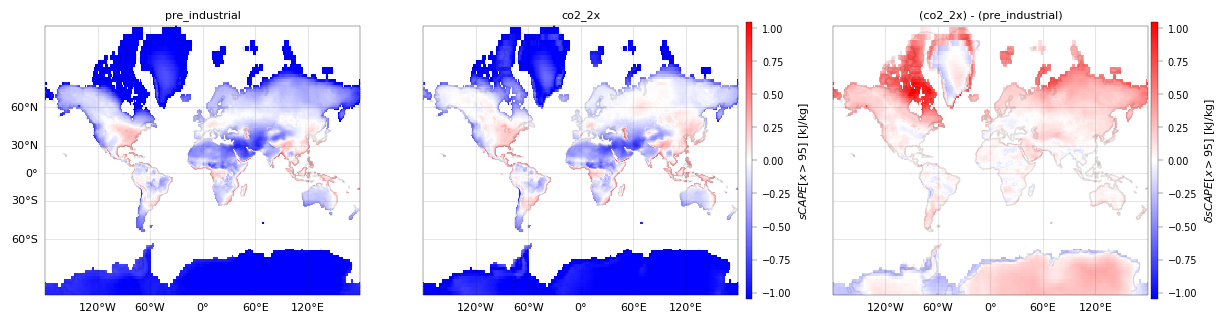

In [44]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 3*im_sz*width['one_col'])
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, ds[i].cape_approx.where(mask_plot),
                     transform=ccrs.PlateCarree(), vmin=-ds[1].cape_approx.max(), vmax=ds[1].cape_approx.max(), cmap='bwr')
    ax[i].set_title(f'{exp_id[i]}')
plt.colorbar(im, ax=ax[:2], label=f'$sCAPE[x>{quant[0]}]$ [kJ/kg]', aspect=40, pad=0.01, fraction=0.03)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds_diff.cape_approx.where(mask_plot),
                      transform=ccrs.PlateCarree(), vmin=-ds[1].cape_approx.max(), vmax=ds[1].cape_approx.max(), cmap='bwr')
ax[2].set_title(f'({exp_id[1]}) - ({exp_id[0]})')
plt.colorbar(im, ax=ax[2:], label=f'$\delta sCAPE[x>{quant[0]}]$ [kJ/kg]', aspect=40, pad=0.01, fraction=0.03)
for i, ax_use in enumerate(ax):
    ax_use.coastlines(alpha=0.1)
    add_gridlines(ax_use, color='k', left_labels=i==0)
plt.show()